In [1]:
import geopandas as gpd
import xarray as xr
import numpy as np
import pandas as pd
from project_utils import fig_utils as figu
from project_utils import utils

In [2]:
import rioxarray

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import pearsonr

In [4]:
import warnings
warnings.filterwarnings("ignore")

In [5]:
figu.set_plt_rc_params()

In [6]:
regions = ["global", "north_pacific", "tropical_pacific", "southern_ocean", "north_atlantic", "tropical_atlantic", "west_indian"]
region_labels = ["Global", "N. Pacific", "Tropical Pac.", "S. Ocean", "N. Atlantic", "Tropical Atl.", "W. Indian"]

In [7]:
model_list=["ACCESS-ESM1-5", "CanESM5", "CNRM-CM6-1", "GISS-E2-1-G", 
            "IPSL-CM6A-LR", "MIROC-ES2L", "MIROC6", "MPI-ESM1-2-LR", "NorCPM1"]
leads = [0, 0, 24]
prediction_lengths = [36, 60, 60]

In [8]:
def get_region_mean(ds, poly, land_mask):
    ds.rio.write_crs('epsg:4326', inplace = True)
    ds.rio.set_spatial_dims("lon", "lat", inplace=True)
    land_mask.rio.write_crs('epsg:4326', inplace = True)
    land_mask.rio.set_spatial_dims("lon", "lat", inplace=True)

    ds_clip = ds.rio.clip(poly.geometry.values)
    weights = utils.get_cell_weights(land_mask.rio.clip(poly.geometry.values))
    
    return((ds_clip*weights.mask).mean(skipna = True, dim = ["lat", "lon"]).score.values)

In [9]:
accuracy_dat = []

for lead, length in zip(leads, prediction_lengths):
    for MODEL in model_list: 
        gcm_acc = xr.open_dataset("../processed_data/accuracy/GCM_accuracy_"+MODEL+"_"+str(length)+"mo_"+str(lead)+"lead.nc")
        gcm_acc40 = xr.open_dataset("../processed_data/accuracy/GCM_accuracy_top40_"+MODEL+"_"+str(length)+"mo_"+str(lead)+"lead.nc")
        gcm_acc20 = xr.open_dataset("../processed_data/accuracy/GCM_accuracy_top20_"+MODEL+"_"+str(length)+"mo_"+str(lead)+"lead.nc")
        obs_acc = xr.open_dataset("../processed_data/accuracy/ERSSTv5_accuracy_"+MODEL+"_"+str(length)+"mo_"+str(lead)+"lead.nc")
        obs_acc40 = xr.open_dataset("../processed_data/accuracy/ERSSTv5_accuracy_top40_"+MODEL+"_"+str(length)+"mo_"+str(lead)+"lead.nc")
        obs_acc20 = xr.open_dataset("../processed_data/accuracy/ERSSTv5_accuracy_top20_"+MODEL+"_"+str(length)+"mo_"+str(lead)+"lead.nc")
        mask = xr.open_dataset("../processed_data/land_mask_5x5_"+MODEL+".nc")
        for REGION in regions: 
            if REGION == "global":
                global_mask = mask.sel(lat = slice(-65, 65))
                accuracy_dat.append(pd.DataFrame({"lead": [lead]*3, 
                                              "length": [length]*3,
                                              "model": [MODEL]*3, 
                                              "region": [REGION]*3,
                                                "subset": ["all", "top40", "top20"], 
                                              "gcm_accuracy": [(gcm_acc*utils.get_cell_weights(global_mask).mask).mean(skipna = True).score.values.item(), 
                                                          (gcm_acc40*utils.get_cell_weights(global_mask).mask).mean(skipna = True).score.values.item(), 
                                                          (gcm_acc20*utils.get_cell_weights(global_mask).mask).mean(skipna = True).score.values.item()], 
                                               "obs_accuracy": [(obs_acc*utils.get_cell_weights(global_mask).mask).mean(skipna = True).score.values.item(), 
                                                          (obs_acc40*utils.get_cell_weights(global_mask).mask).mean(skipna = True).score.values.item(), 
                                                          (obs_acc20*utils.get_cell_weights(global_mask).mask).mean(skipna = True).score.values.item()], 
                                                "gcm_acc_low": [(gcm_acc*utils.get_cell_weights(global_mask).mask).mean(skipna = True, dim = ["lat", "lon"]).score.values.min(), 
                                                          (gcm_acc40*utils.get_cell_weights(global_mask).mask).mean(skipna = True, dim = ["lat", "lon"]).score.values.min(), 
                                                          (gcm_acc20*utils.get_cell_weights(global_mask).mask).mean(skipna = True, dim = ["lat", "lon"]).score.values.min()], 
                                                 "gcm_acc_high": [(gcm_acc*utils.get_cell_weights(global_mask).mask).mean(skipna = True, dim = ["lat", "lon"]).score.values.max(), 
                                                          (gcm_acc40*utils.get_cell_weights(global_mask).mask).mean(skipna = True, dim = ["lat", "lon"]).score.values.max(), 
                                                          (gcm_acc20*utils.get_cell_weights(global_mask).mask).mean(skipna = True, dim = ["lat", "lon"]).score.values.max()]}))
            else: 
                poly = gpd.read_file("../processed_data/region_shapefiles/"+REGION+".shp")
                accuracy_dat.append(pd.DataFrame({"lead": [lead]*3, 
                                              "length": [length]*3,
                                              "model": [MODEL]*3, 
                                              "region": [REGION]*3,
                                                  "subset": ["all", "top40", "top20"], 
                                              "gcm_accuracy": [get_region_mean(gcm_acc, poly, mask).mean(), 
                                                          get_region_mean(gcm_acc40, poly, mask).mean(), 
                                                          get_region_mean(gcm_acc20, poly, mask).mean()], 
                                            "obs_accuracy": [get_region_mean(obs_acc, poly, mask).item(), 
                                                          get_region_mean(obs_acc40, poly, mask).item(), 
                                                          get_region_mean(obs_acc20, poly, mask).item()], 
                                                 "gcm_acc_low": [get_region_mean(gcm_acc, poly, mask).min(), 
                                                          get_region_mean(gcm_acc40, poly, mask).min(), 
                                                          get_region_mean(gcm_acc20, poly, mask).min()], 
                                                 "gcm_acc_high": [get_region_mean(gcm_acc, poly, mask).max(), 
                                                          get_region_mean(gcm_acc40, poly, mask).max(), 
                                                          get_region_mean(gcm_acc20, poly, mask).max()]}))

In [10]:
accuracy_dat = pd.concat(accuracy_dat, ignore_index=True)
accuracy_dat.to_csv("../processed_data/cnn_accuracy_summary.csv", index=False)

In [11]:
accuracy_dat.describe()

,lead,length,gcm_accuracy,obs_accuracy,gcm_acc_low,gcm_acc_high
count,567.000000,567.000000,567.000000,567.000000,567.000000,567.000000
mean,8.000000,52.000000,0.482531,0.438684,0.449176,0.518439
std,11.323699,11.323699,0.086446,0.068003,0.080353,0.098843
min,0.000000,36.000000,0.348765,0.291545,0.322601,0.358536
25%,0.000000,36.000000,0.414824,0.387992,0.390155,0.440058
50%,0.000000,60.000000,0.468792,0.428914,0.433337,0.501795
75%,24.000000,60.000000,0.530689,0.486658,0.488145,0.578432
max,24.000000,60.000000,0.828755,0.640987,0.804932,0.874868


In [12]:
model_palette = ["#589695", "#3a494c", "#a8533f", "#c1771e", "#b8859d", "#7e5e4a", "#93964b", "#788b92", "#597647"]

In [13]:
panel_labels = ["a) ", "b) ", "c) ", "d) ", "e) ", "f) ", "g) ", "h) ", "i) ", 
               "j) ", "k) ", "l) ", "m) ", "n) ", "o) ", "p) ", "q) ", "r) ", "s) ", "t) ", "u) "]

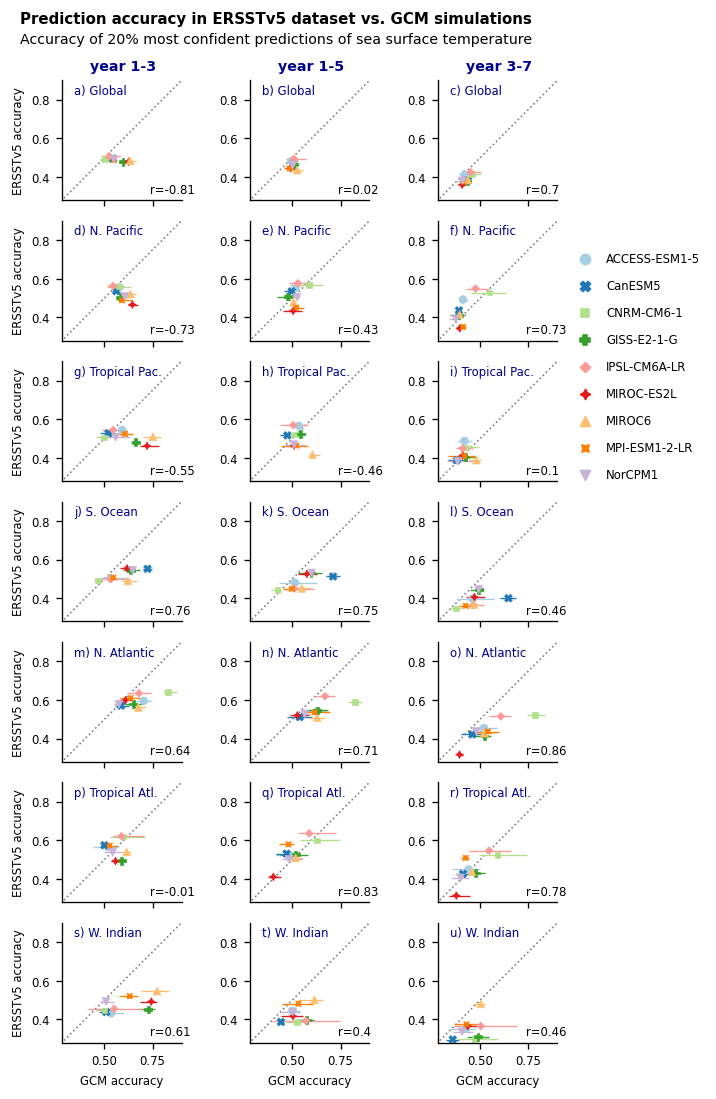

In [14]:
fig = plt.figure(figsize = (5.8, 9))
label_count = 0

ax_width = 0.172
ax_height = 0.111
sns.set_palette("Paired")
## Col 1 - 36 month 0 lead
for i, (REGION, region_label) in enumerate(zip(regions, region_labels)):
    df = accuracy_dat[(accuracy_dat.lead == 0) & (accuracy_dat.length == 36) & (accuracy_dat.subset == "top20") & (accuracy_dat.region == REGION)].copy()
    ax = fig.add_axes([0.08, 0.82 - i*(ax_height+0.019), ax_width, ax_height])
    sns.scatterplot(data=df, x='gcm_accuracy', y='obs_accuracy', style='model', hue = 'model', s = 22, edgecolor=None, zorder = 2)
    ax.errorbar(x = df.gcm_accuracy, y = df.obs_accuracy, 
                xerr = [df.gcm_accuracy - df.gcm_acc_low, df.gcm_acc_high- df.gcm_accuracy], fmt='none', zorder = 1, lw = 0.8,
               ecolor = sns.color_palette("Paired", 9))
    ax.get_legend().remove()
    ax.plot([0, 0.9], [0, 0.9], linestyle = "dotted", color = "gray", zorder = 0)
    ax.set_xlim([0.28, 0.9])
    ax.set_ylim([0.28, 0.9])
    ax.set_title(panel_labels[label_count]+region_label, 
                 size = 7, y = 0.8, x = 0.1, ha = "left", color = "darkblue")
    label_count+=1
    ax.text(s = "r="+str(round(pearsonr(df.gcm_accuracy, df.obs_accuracy).statistic, 2)), 
            x = 0.74, y = 0.06, transform = ax.transAxes, size = 7)
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.set_ylabel("ERSSTv5 accuracy", labelpad = 4)
    if i < 6:
        plt.tick_params(labelbottom=False)
        ax.set_xlabel("")
    if i == 6:
        ax.set_xlabel("GCM accuracy")
        
## Col 2 - 60 month 0 lead
    df = accuracy_dat[(accuracy_dat.lead == 0) & (accuracy_dat.length == 60) & (accuracy_dat.subset == "top20") & (accuracy_dat.region == REGION)].copy()
    ax = fig.add_axes([0.35, 0.82 - i*(ax_height+0.019), ax_width, ax_height])
    sns.scatterplot(data=df, x='gcm_accuracy', y='obs_accuracy', style='model', hue = 'model', s = 22, edgecolor=None, zorder = 2)
    ax.errorbar(x = df.gcm_accuracy, y = df.obs_accuracy, 
                xerr = [df.gcm_accuracy - df.gcm_acc_low, df.gcm_acc_high- df.gcm_accuracy], fmt='none', zorder = 1, lw = 0.8, 
               ecolor = sns.color_palette("Paired", 9))
    ax.get_legend().remove()
    ax.plot([0, 0.9], [0, 0.9], linestyle = "dotted", color = "gray", zorder = 0)
    ax.set_xlim([0.28, 0.9])
    ax.set_ylim([0.28, 0.9])
    ax.set_title(panel_labels[label_count]+region_label, 
                 size = 7, y = 0.8, x = 0.1, ha = "left", color = "darkblue")
    label_count+=1
    ax.text(s = "r="+str(round(pearsonr(df.gcm_accuracy, df.obs_accuracy).statistic, 2)), 
            x = 0.74, y = 0.06, transform = ax.transAxes, size = 7)
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.set_ylabel("")
    if i < 6:
        plt.tick_params(labelbottom=False)
        ax.set_xlabel("")
    if i == 6:
        ax.set_xlabel("GCM accuracy")
        
## Col 3 - 60 month 24 lead
    df = accuracy_dat[(accuracy_dat.lead == 24) & (accuracy_dat.length == 60) & (accuracy_dat.subset == "top20") & (accuracy_dat.region == REGION)].copy()
    ax = fig.add_axes([0.62, 0.82 - i*(ax_height+0.019), ax_width, ax_height])
    sns.scatterplot(data=df, x='gcm_accuracy', y='obs_accuracy', style='model', hue = 'model', s = 22, edgecolor=None, zorder = 2)
    ax.errorbar(x = df.gcm_accuracy, y = df.obs_accuracy, 
                xerr = [df.gcm_accuracy - df.gcm_acc_low, df.gcm_acc_high- df.gcm_accuracy], fmt='none', zorder = 1, lw = 0.8, 
               ecolor = sns.color_palette("Paired", 9))
    ax.get_legend().remove()
    ax.plot([0, 0.9], [0, 0.9], linestyle = "dotted", color = "gray", zorder = 0)
    ax.set_xlim([0.28, 0.9])
    ax.set_ylim([0.28, 0.9])
    ax.set_title(panel_labels[label_count]+region_label, 
                 size = 7, y = 0.8, x = 0.1, ha = "left", color = "darkblue")
    label_count+=1
    ax.text(s = "r="+str(round(pearsonr(df.gcm_accuracy, df.obs_accuracy).statistic, 2)), 
            x = 0.74, y = 0.06, transform = ax.transAxes, size = 7)
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.set_ylabel("")
    if i < 6:
        plt.tick_params(labelbottom=False)
        ax.set_xlabel("")
    if i == 6:
        ax.set_xlabel("GCM accuracy")

plt.suptitle("Prediction accuracy in ERSSTv5 dataset vs. GCM simulations", y = 0.995, x = 0.02, size = 9, ha = "left", weight = "bold")
ax.text(s = "Accuracy of 20% most confident predictions of sea surface temperature", x = 0.02, y = 0.965,
       transform = fig.transFigure, size = 8.5)
ax.text(s = "year 1-3", y = 0.94, x = 0.12, color = "darkblue", weight = "bold",  
             transform = fig.transFigure, size = 8.5)
ax.text(s = "year 1-5", y = 0.94, x = 0.39, color = "darkblue", weight = "bold",  
             transform = fig.transFigure, size = 8.5)
ax.text(s = "year 3-7", y = 0.94, x = 0.66, color = "darkblue", weight = "bold",  
             transform = fig.transFigure, size = 8.5)

handles, labels = ax.get_legend_handles_labels()
fig.legend(handles[0:9], labels[0:9], frameon=False, bbox_to_anchor=[0.8, 0.55], loc = "lower left", ncol=1, labelspacing=1.2)
plt.savefig("../figures/Fig4_accuracy_comparisons.pdf")